# ETH-USD Forecast Project

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets
from datetime import datetime, timedelta
import plotly
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import itertools
import json
from fbprophet.serialize import model_to_json

sns.set()

### Pull and format Yahoo Finance (Coinmarketcap) data

In [35]:
#Set and format date range for data (as 'close' prices are used, the end date is set to the day before the current date)
start_date = '2016-01-02'
end_date = datetime.today() - timedelta(1)
end_date = datetime.strftime(end_date, '%Y-%m-%d')

In [36]:
#Download data
yf_data = yf.download('ETH-USD',start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [37]:
#Check data types 
yf_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2144 entries, 2016-01-01 to 2021-11-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2144 non-null   float64
 1   High       2144 non-null   float64
 2   Low        2144 non-null   float64
 3   Close      2144 non-null   float64
 4   Adj Close  2144 non-null   float64
 5   Volume     2144 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 117.2 KB


In [38]:
#Check for missing 'price' values
yf_data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [39]:
#Drop features that aren't required
yf_data = yf_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1)

In [40]:
#Check for missing 'date' values 
pd.date_range(start = start_date, end = end_date ).difference(yf_data.index)

DatetimeIndex(['2020-04-17', '2020-10-09', '2020-10-12', '2020-10-13',
               '2021-11-18'],
              dtype='datetime64[ns]', freq=None)

In [41]:
#Create new data range that accounts missing dates and 'forward fill' price values
new_date_range = pd.date_range(start = start_date, end = end_date, freq="D")
yf_data = yf_data.reindex(new_date_range, method = 'ffill')

In [42]:
#Confirm that missing 'dates' have been resolved
pd.date_range(start = start_date, end = end_date ).difference(yf_data.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

In [43]:
#Check tail of dataframe
yf_data.tail(10)

Close
2021-11-09  4735.068848
2021-11-10  4636.174316
2021-11-11  4730.384277
2021-11-12  4667.115234
2021-11-13  4651.460449
2021-11-14  4626.358887
2021-11-15  4557.503906
2021-11-16  4216.365234
2021-11-17  4287.593750
2021-11-18  4287.593750

In [44]:
#Prohpet requires a dataframe with 'ds' (datestamp) and 'y' columns. As the date is currently a pandas Datetime index, the index needs to be reset with the dates converted to a feature  
prophet_df = yf_data.reset_index(level = 0)

In [45]:
#Rename features
prophet_df = prophet_df.rename({'index': 'ds', 'Close': 'y'}, axis = 1)
prophet_df

ds            y
0    2016-01-02     0.937124
1    2016-01-03     0.971905
2    2016-01-04     0.954480
3    2016-01-05     0.950176
4    2016-01-06     0.950860
...         ...          ...
2143 2021-11-14  4626.358887
2144 2021-11-15  4557.503906
2145 2021-11-16  4216.365234
2146 2021-11-17  4287.593750
2147 2021-11-18  4287.593750

[2148 rows x 2 columns]

### Create baseline model

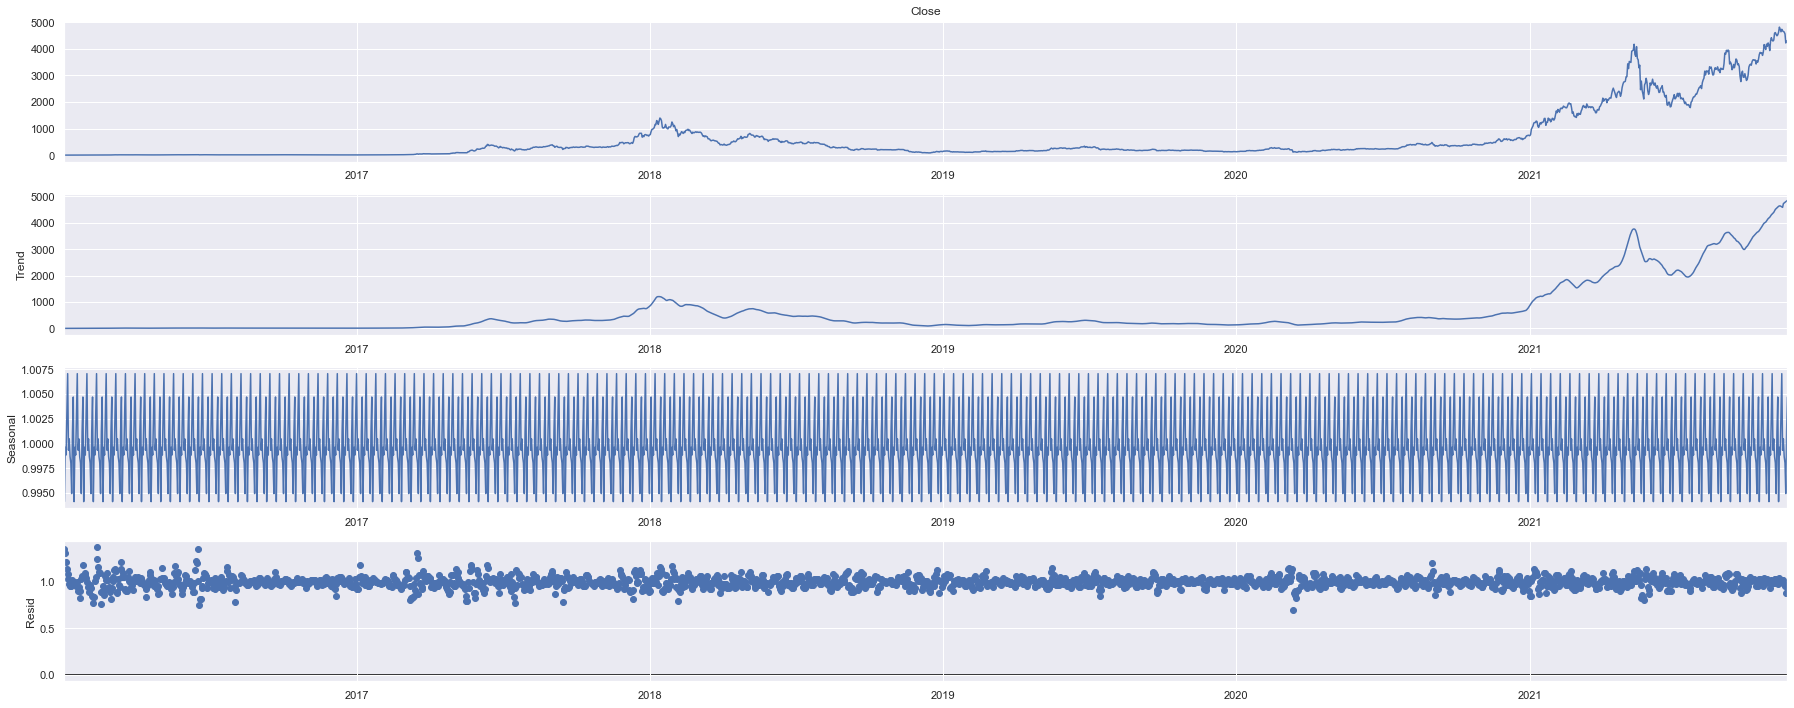

In [46]:
#Check seasonal decomposition to confirm that the Prophet algorithm is suitable for modelling
decomp = seasonal_decompose(yf_data['Close'], model = 'multiplicative', extrapolate_trend = 'freq', period = 12)
plt.rcParams.update({'figure.figsize': (25,10)})
decomp.plot()
plt.show()

In [47]:
#Create baseline Prophet model. It is clear from the seasonal decomposition that 'multiplicative' process is probably most suitable. Confidence intervals have also been set to 95%. 
model = Prophet(
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    interval_width = 0.95
)
model.fit(prophet_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [48]:
#Set a forecast horizon of 60 days
future = model.make_future_dataframe(periods = 60)

In [49]:
#Get predicted values for the forecast horizon and retain needed columns
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
2203 2022-01-13  4846.302201  4581.498961  5093.964789
2204 2022-01-14  4846.825957  4621.056285  5100.072312
2205 2022-01-15  4863.642070  4595.796341  5106.590607
2206 2022-01-16  4877.918685  4601.494420  5116.879784
2207 2022-01-17  4876.069933  4594.123791  5126.062488

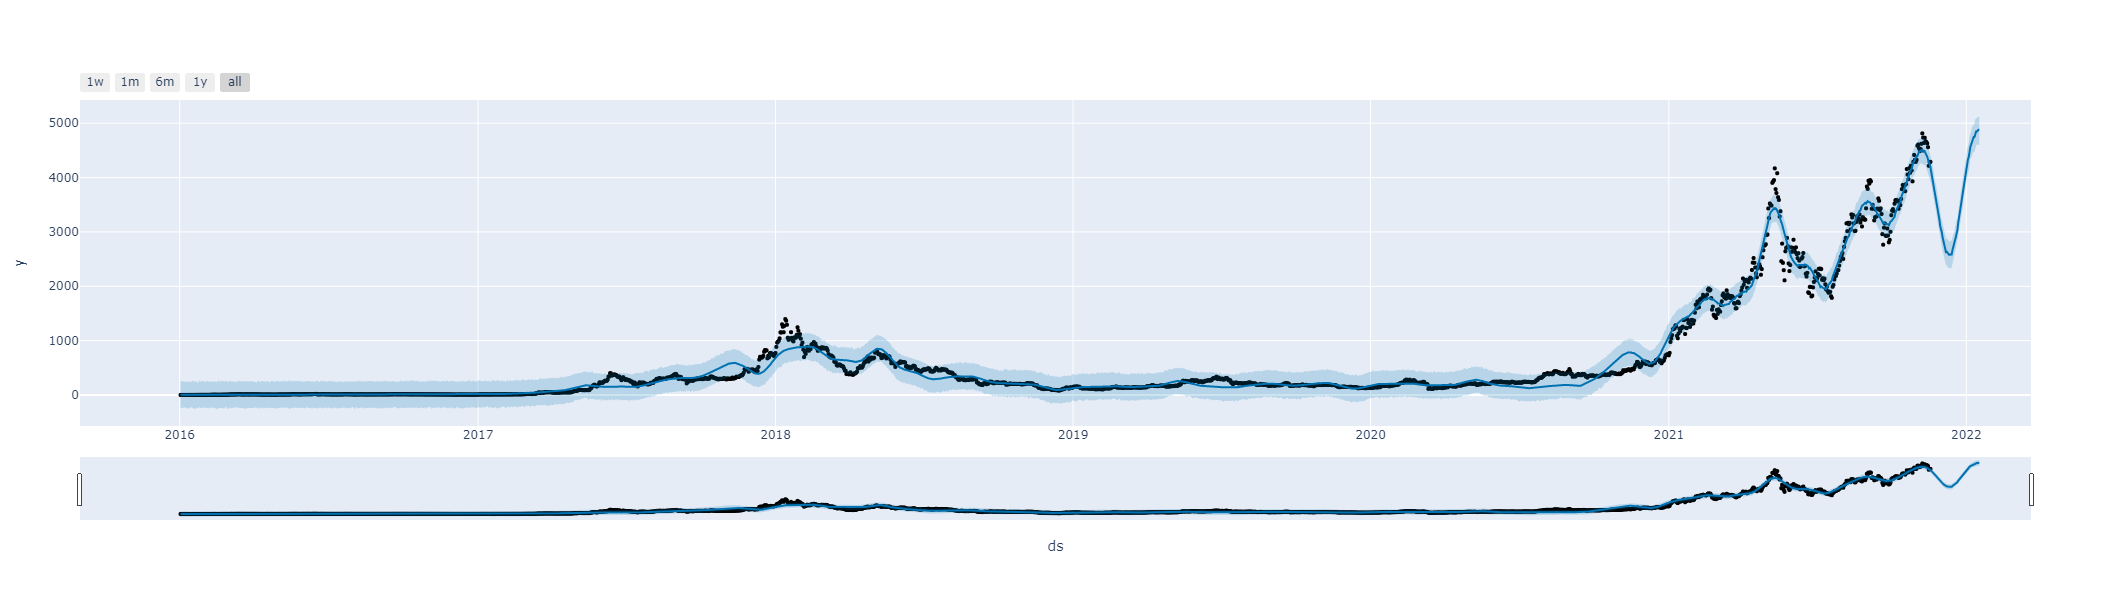

In [50]:
#Use the Prophet library plotly plotting method for visualise the forecast
plot_plotly(model, forecast)

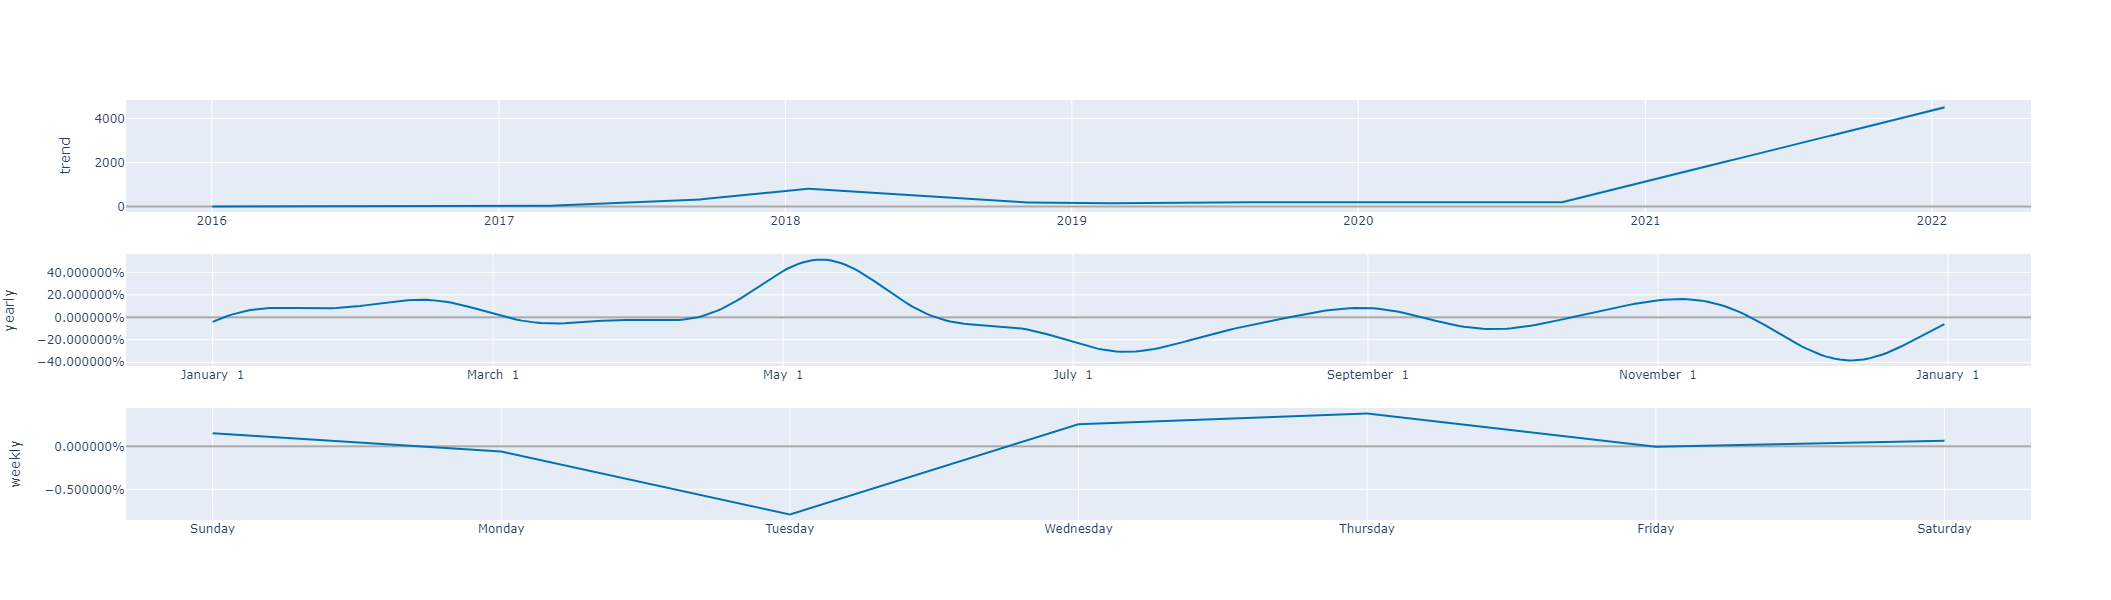

In [51]:
#As Prophet employs an 'additive' modelling process, use the in-build plotting methods to visualise each component modeled 
plot_components_plotly(model, forecast)

### Cross-validate baseline model

In [52]:
#Use the Prophet 'cross-validation' method to perform cross-validation
df_cv = cross_validation(model, initial='730 days', period='30 days', horizon = '60 days')

INFO:fbprophet:Making 46 forecasts with cutoffs between 2018-01-08 00:00:00 and 2021-09-19 00:00:00


  0%|          | 0/46 [00:00<?, ?it/s]

In [53]:
#Check cross-validation results
df_cv.head(10)

ds         yhat   yhat_lower   yhat_upper            y     cutoff
0 2018-01-09  1319.040473  1284.923850  1353.303774  1299.739990 2018-01-08
1 2018-01-10  1427.259847  1390.827220  1461.752304  1255.819946 2018-01-08
2 2018-01-11  1541.295245  1504.023096  1576.475596  1154.930054 2018-01-08
3 2018-01-12  1668.776524  1634.768885  1702.490767  1273.199951 2018-01-08
4 2018-01-13  1815.537881  1781.207678  1850.225909  1396.420044 2018-01-08
5 2018-01-14  1974.433866  1941.891939  2010.218036  1366.770020 2018-01-08
6 2018-01-15  2153.841666  2121.211795  2187.467233  1291.920044 2018-01-08
7 2018-01-16  2356.748244  2322.515973  2392.735511  1053.689941 2018-01-08
8 2018-01-17  2544.941926  2512.105502  2577.654006  1014.250000 2018-01-08
9 2018-01-18  2732.883407  2701.147075  2770.543164  1036.280029 2018-01-08

In [54]:
#Use the Prophet 'performance_metrics' method to get perfromance metrics for the cross-validation results
df_p = performance_metrics(df_cv)

In [55]:
#Check cross-validation performance
df_p

horizon            mse        rmse         mae      mape     mdape  \
0   6 days   28222.406531  167.995257  123.101286  0.305504  0.218136   
1   7 days   36444.858924  190.905366  137.332736  0.323806  0.226147   
2   8 days   50928.672942  225.673820  154.414898  0.343019  0.234594   
3   9 days   70856.621424  266.189071  174.149870  0.362255  0.247720   
4  10 days   94025.953867  306.636518  192.808051  0.380157  0.258305   
5  11 days  126970.315508  356.328943  215.477023  0.397800  0.271930   
6  12 days  170274.677399  412.643523  242.682031  0.414967  0.293173   
7  13 days  218015.284746  466.921069  268.482345  0.430673  0.313563   
8  14 days  271057.417862  520.631749  294.173209  0.445021  0.326928   
9  15 days  324760.505592  569.877623  318.233490  0.460224  0.345867   
10 16 days  386954.285290  622.056497  344.167869  0.474540  0.364037   
11 17 days  447172.976085  668.709934  366.875795  0.489764  0.381584   
12 18 days  495337.491927  703.802168  384.395961  0.505835  0.395468   
13 19 days  543531.632590  737.245978  400.458740  0.520005  0.402868   
14 20 days  576865.241000  759.516452  412.749707  0.533754  0.435500   
15 21 days  604380.142213  777.418898  421.003342  0.544777  0.448387   
16 22 days  632882.157492  795.538910  427.150187  0.557480  0.458330   
17 23 days  653982.564469  808.691885  432.406694  0.569471  0.461056   
18 24 days  676308.377616  822.379704  436.499289  0.578493  0.463673   
19 25 days  694418.269339  833.317628  438.350259  0.590151  0.468997   
20 26 days  717722.948406  847.185309  440.847972  0.600681  0.473714   
21 27 days  733001.314700  856.154960  440.109743  0.612628  0.477943   
22 28 days  736738.573615  858.334768  437.350794  0.625583  0.476743   
23 29 days  732490.495183  855.856586  430.839355  0.632650  0.477943   
24 30 days  727357.167697  852.852372  426.890701  0.642154  0.481127   
25 31 days  708385.731477  841.656540  420.184346  0.647386  0.465049   
26 32 days  678468.100570  823.691751  411.899921  0.651707  0.454660   
27 33 days  655650.166794  809.722278  409.242551  0.655517  0.454257   
28 34 days  630777.638012  794.215108  407.007169  0.656565  0.448854   
29 35 days  603321.322489  776.737615  405.117854  0.659739  0.441961   
30 36 days  573165.726697  757.077094  400.563543  0.662348  0.431040   
31 37 days  547648.131712  740.032521  398.337876  0.664387  0.425084   
32 38 days  524204.125275  724.019423  396.420167  0.664156  0.425306   
33 39 days  504954.468817  710.601484  395.279592  0.661611  0.424672   
34 40 days  485935.375875  697.090651  393.930880  0.657891  0.425306   
35 41 days  481826.011102  694.136882  397.571827  0.656162  0.426375   
36 42 days  487391.094880  698.134009  405.120425  0.652112  0.434394   
37 43 days  501236.623448  707.980666  414.123694  0.647641  0.438397   
38 44 days  532888.674022  729.992242  425.989510  0.643461  0.444819   
39 45 days  560146.140129  748.429115  436.420993  0.641461  0.449090   
40 46 days  596122.961376  772.089996  448.329162  0.635529  0.453982   
41 47 days  629766.574684  793.578336  458.356033  0.632259  0.457796   
42 48 days  650930.683951  806.802754  464.506318  0.630843  0.469489   
43 49 days  677163.280988  822.899314  470.743376  0.630980  0.473157   
44 50 days  692337.296911  832.068084  474.917577  0.634591  0.477889   
45 51 days  703040.903819  838.475345  477.808906  0.638133  0.482223   
46 52 days  711433.672767  843.465277  480.738293  0.647315  0.496204   
47 53 days  719241.119509  848.080845  484.667209  0.655542  0.501451   
48 54 days  729732.069248  854.243566  488.499272  0.659727  0.508687   
49 55 days  730296.913899  854.574113  490.882389  0.666158  0.518377   
50 56 days  735120.750970  857.391830  493.988711  0.672506  0.522930   
51 57 days  729113.427093  853.881389  492.859195  0.676231  0.529333   
52 58 days  711464.168635  843.483354  488.876098  0.677446  0.547638   
53 59 days  688370.062072  829.680699  481.778794  0.676771  

### Tune model with grid-search

In [57]:
#Define cutoffs
cutoffs = pd.to_datetime(['2018-01-01', '2018-04-01', '2019-01-01', '2020-01-01'])

#Define parameter grid for 'changepoint_prior_scale' and 'seasonality_prior_scale' with recommended values
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

#reate list containing all parameter combinations
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mae = [] 

#Perfrom grid-search using mean absolute error (mae) as evaluation metric
for params in all_params:
    m = Prophet(**params, seasonality_mode="multiplicative").fit(prophet_df) 
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon = '60 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mae.append(df_p['mae'].values[0])

##Create dataframe of results
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = mae
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000021EE220ACA0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000021EE24CBFA0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000021EE6EDA1F0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000021EE6F49250>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet

    changepoint_prior_scale  seasonality_prior_scale          mae
0                     0.001                     0.01   306.520233
1                     0.001                     0.10   527.998294
2                     0.001                     1.00   386.702441
3                     0.001                    10.00   510.754492
4                     0.010                     0.01   235.495230
5                     0.010                     0.10   290.735959
6                     0.010                     1.00   311.312059
7                     0.010                    10.00   310.142478
8                     0.100                     0.01   285.031374
9                     0.100                     0.10   187.416424
10                    0.100                     1.00   256.649995
11                    0.100                    10.00   257.321873
12                    0.500                     0.01   301.374620
13                    0.500                     0.10   167.961417
14        

In [58]:
#Sort grid-search results to obtain most suitable parameter values
tuning_results.sort_values(['mae'])

changepoint_prior_scale  seasonality_prior_scale          mae
13                    0.500                     0.10   167.961417
9                     0.100                     0.10   187.416424
4                     0.010                     0.01   235.495230
10                    0.100                     1.00   256.649995
11                    0.100                    10.00   257.321873
8                     0.100                     0.01   285.031374
5                     0.010                     0.10   290.735959
12                    0.500                     0.01   301.374620
0                     0.001                     0.01   306.520233
7                     0.010                    10.00   310.142478
6                     0.010                     1.00   311.312059
2                     0.001                     1.00   386.702441
3                     0.001                    10.00   510.754492
1                     0.001                     0.10   527.998294
14                    0.500                     1.00  1834.981050
15                    0.500                    10.00  2120.203841

### Create tuned model

In [59]:
#Create Prophet model using tuned parameter values
tuned_prophet = Prophet(
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    interval_width = 0.95,
    changepoint_prior_scale = 0.5,
    seasonality_prior_scale = 0.1
    
    
)
tuned_prophet.fit(prophet_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [60]:
#Set a forecast horizon of 60 days
tuned_future = tuned_prophet.make_future_dataframe(periods = 60)

In [61]:
#Get predicted values for the forecast horizon using the tuned model and retain required columns
tuned_forecast = tuned_prophet.predict(future)
tuned_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
2203 2022-01-13  4698.619429  4302.298806  5059.995096
2204 2022-01-14  4690.252443  4307.760373  5084.043514
2205 2022-01-15  4693.955636  4323.777239  5040.776793
2206 2022-01-16  4692.706114  4285.488624  5046.712867
2207 2022-01-17  4674.785254  4255.834824  5058.249284

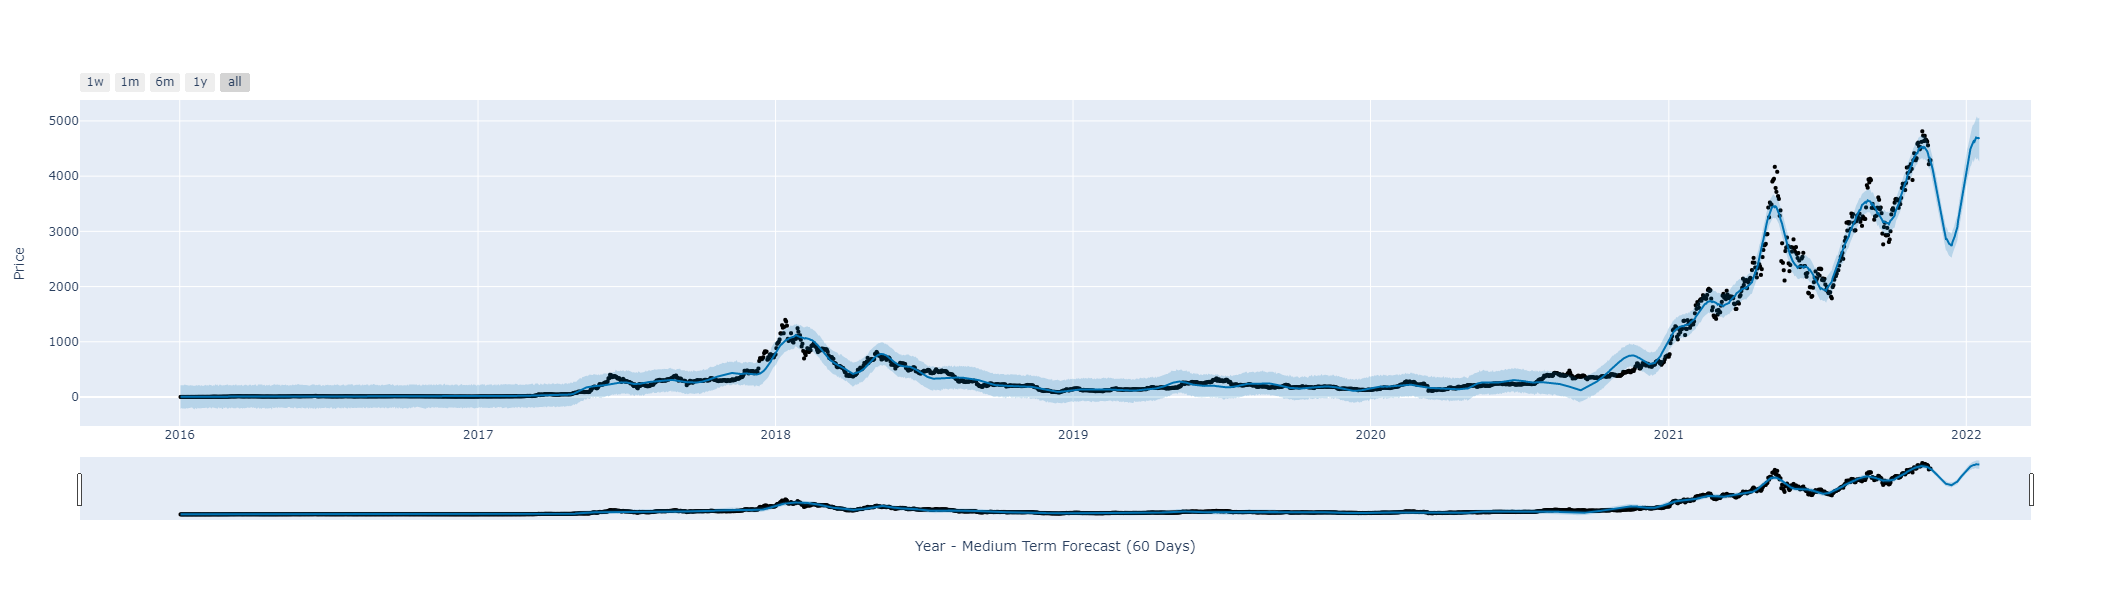

In [62]:
#Plot 60 day forecast (using Prohpet library 'plot_plotly' method)
long_plot = plot_plotly(tuned_prophet, tuned_forecast,
                       xlabel = 'Year - Medium Term Forecast (60 Days) ',
                       ylabel = 'Price')
long_plot

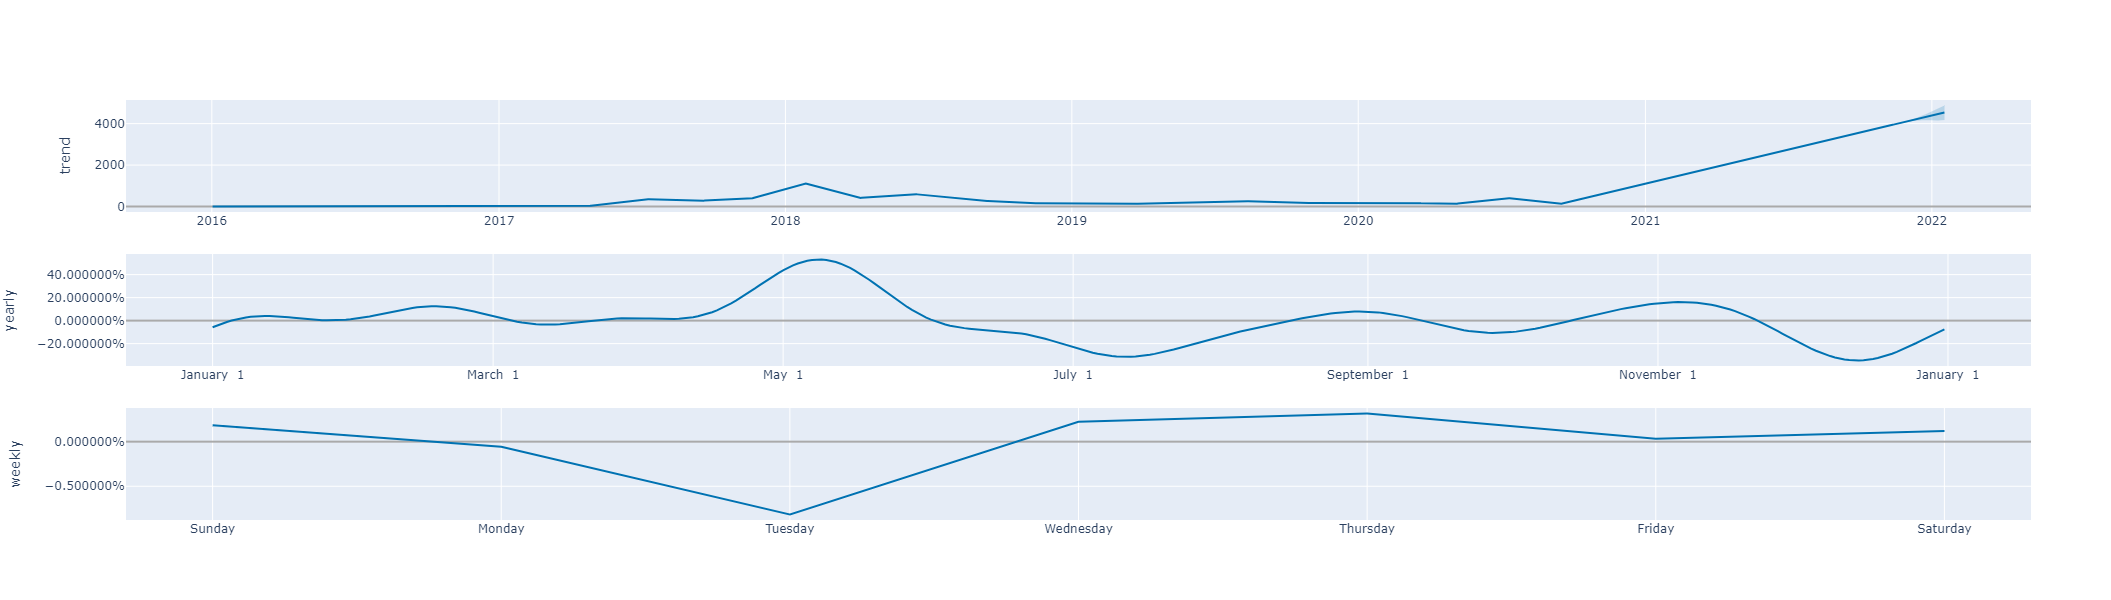

In [63]:
#Plot components for tuned model (using Prophet library 'plot_components_plotly' method)
components_plot = plot_components_plotly(tuned_prophet, tuned_forecast)
components_plot

### Cross-validate tuned model

In [64]:
#Perfrom cross-validation for the tuned model (using the Prophet library 'cross_validation' method)
tuned_df_cv = cross_validation(tuned_prophet, initial='730 days', period='30 days', horizon = '60 days')

INFO:fbprophet:Making 46 forecasts with cutoffs between 2018-01-08 00:00:00 and 2021-09-19 00:00:00


  0%|          | 0/46 [00:00<?, ?it/s]

In [75]:
#Get porformance metrics for the tuned model
tuned_df_p = performance_metrics(tuned_df_cv)

In [76]:
#Check performance metrics for the tuned model
tuned_df_p

horizon            mse        rmse         mae      mape     mdape  \
0   6 days   22650.954216  150.502340   94.427770  0.180618  0.143013   
1   7 days   29918.249894  172.968928  107.113069  0.195534  0.149730   
2   8 days   43260.354226  207.991236  122.047912  0.212004  0.159194   
3   9 days   62719.423248  250.438462  140.994086  0.231588  0.176799   
4  10 days   85436.599708  292.295398  158.406210  0.248049  0.186159   
5  11 days  117865.368333  343.315261  180.965218  0.266251  0.201289   
6  12 days  160608.912580  400.760418  208.304918  0.285225  0.220776   
7  13 days  208127.933111  456.210404  234.446389  0.303956  0.241872   
8  14 days  261585.478763  511.454278  261.417254  0.324670  0.265833   
9  15 days  316288.695029  562.395497  286.261394  0.343794  0.288908   
10 16 days  379355.756827  615.918628  313.829907  0.363758  0.301675   
11 17 days  441392.435196  664.373717  337.306304  0.382098  0.304316   
12 18 days  492322.642523  701.657069  355.549638  0.401238  0.310095   
13 19 days  543003.906682  736.887988  371.617620  0.415827  0.311284   
14 20 days  578820.520462  760.802550  382.715740  0.426262  0.316366   
15 21 days  609226.769584  780.529801  390.484619  0.433741  0.323066   
16 22 days  641389.955791  800.868251  397.316731  0.444824  0.343944   
17 23 days  665946.550347  816.055482  403.352760  0.456164  0.347912   
18 24 days  691475.067412  831.549799  408.431130  0.464743  0.336305   
19 25 days  712865.378868  844.313555  412.149785  0.477312  0.336305   
20 26 days  738334.915843  859.264171  417.117709  0.488709  0.329392   
21 27 days  755606.195614  869.256116  418.476547  0.503738  0.328469   
22 28 days  760763.138595  872.217369  416.698587  0.518151  0.327438   
23 29 days  756770.575102  869.925615  411.127321  0.526846  0.318604   
24 30 days  750847.752239  866.514716  407.650484  0.536946  0.322833   
25 31 days  730603.275691  854.753342  401.292686  0.542254  0.328870   
26 32 days  699075.055774  836.107084  393.015060  0.545998  0.333453   
27 33 days  673004.848262  820.368727  389.955968  0.547553  0.357830   
28 34 days  644601.261462  802.870638  388.169911  0.547090  0.372347   
29 35 days  614451.464872  783.869546  387.586073  0.550118  0.386951   
30 36 days  582501.285356  763.217718  384.447430  0.552607  0.397026   
31 37 days  555747.774982  745.484926  383.914857  0.555477  0.398811   
32 38 days  532639.249912  729.821382  384.542233  0.559369  0.401818   
33 39 days  514742.917160  717.455864  386.514213  0.563211  0.400789   
34 40 days  497871.198805  705.599886  387.507328  0.565050  0.400555   
35 41 days  496740.422265  704.798143  393.090556  0.566799  0.407198   
36 42 days  505311.525643  710.852675  403.255040  0.568914  0.414710   
37 43 days  522720.406322  722.994057  415.330755  0.572936  0.414199   
38 44 days  557774.249454  746.842855  430.392671  0.576792  0.420749   
39 45 days  588615.293235  767.212678  444.181020  0.582651  0.453781   
40 46 days  628016.104116  792.474671  459.894907  0.585695  0.468560   
41 47 days  664846.375317  815.381123  473.576649  0.591061  0.479469   
42 48 days  689304.510554  830.243645  482.856131  0.596204  0.495706   
43 49 days  717935.017440  847.310461  491.396494  0.598939  0.500185   
44 50 days  734668.936266  857.128308  497.314922  0.603982  0.503551   
45 51 days  747490.510530  864.575335  501.384768  0.606838  0.511213   
46 52 days  758964.655547  871.185776  505.254176  0.613897  0.515905   
47 53 days  769464.375327  877.191185  510.199040  0.621799  0.526622   
48 54 days  783262.239424  885.021039  515.691287  0.627916  0.531569   
49 55 days  787943.653655  887.661903  519.802389  0.636397  0.542501   
50 56 days  799404.090710  894.094006  525.246353  0.644652  0.545030   
51 57 days  801605.256160  895.324107  527.744309  0.653109  0.545528   
52 58 days  795422.490646  891.864615  528.574644  0.661842  0.550379   
53 59 days  786485.791739  886.840342  526.720742  0.668924  

In [77]:
#Set horizon for short-term forecast
short_term = tuned_prophet.make_future_dataframe(periods = 10)

In [78]:
##Get predicted values for the short-term forecast using the tuned model and retain required columns
short_term_forecast = tuned_prophet.predict(short_term)
short_term_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
2153 2021-11-24  3885.753206  3676.600321  4106.962515
2154 2021-11-25  3809.425851  3607.038790  4000.923818
2155 2021-11-26  3715.658938  3504.774596  3930.827031
2156 2021-11-27  3635.475424  3423.933812  3846.103824
2157 2021-11-28  3553.569597  3338.922776  3755.800850

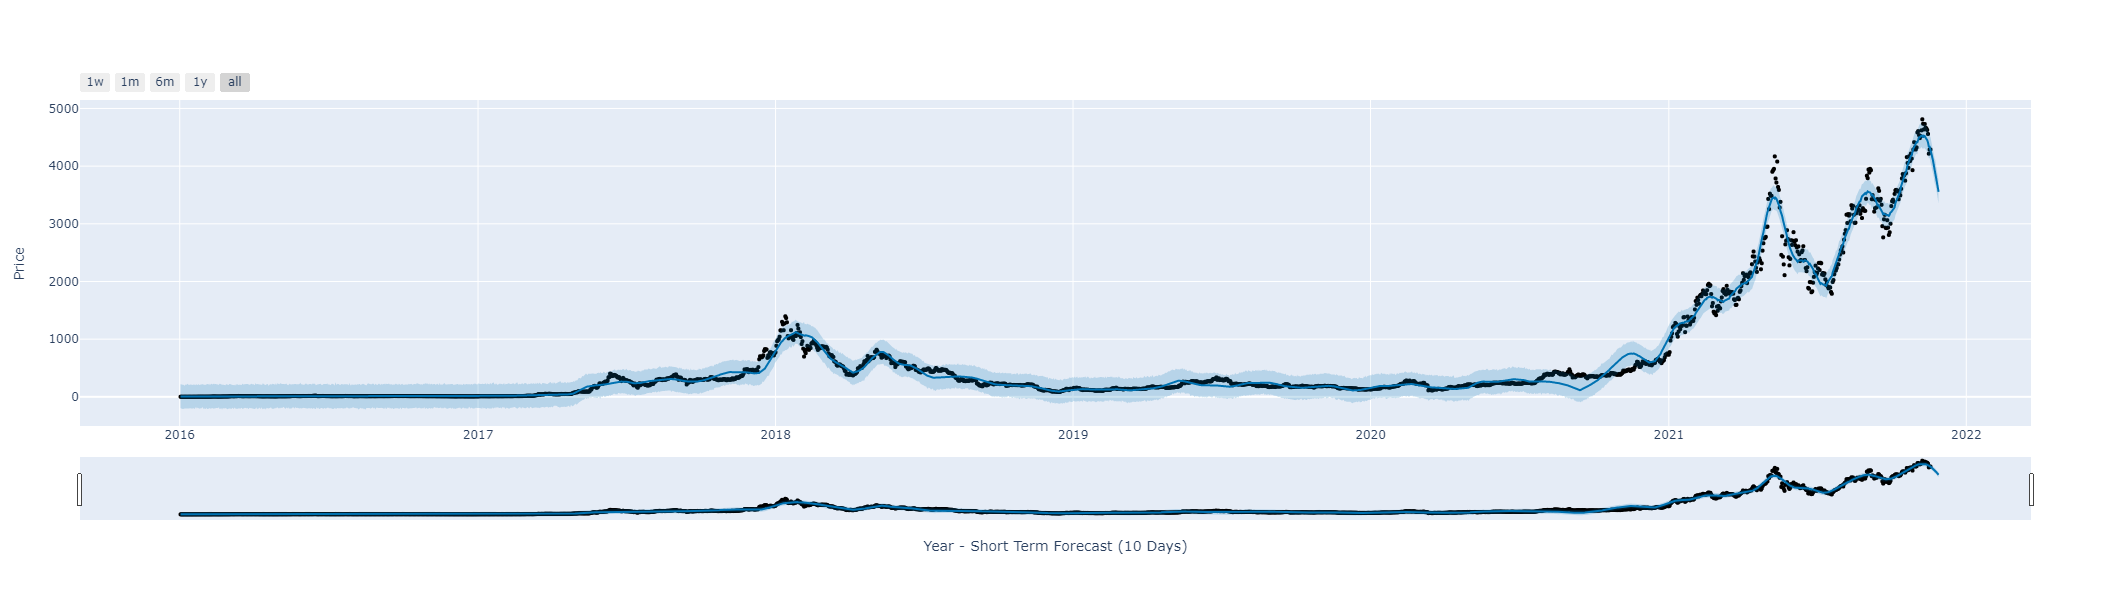

In [79]:
#Plot short-term forecast 
short_plot = plot_plotly(tuned_prophet, short_term_forecast,
                        xlabel = 'Year - Short Term Forecast (10 Days)',
                        ylabel = 'Price',
                        )
short_plot

### Create table of cross-validation metrics for users

In [70]:
#Get performance metrics of interest
forecast_outlook = tuned_df_p[['horizon', 'mae', 'mape']][:9]

In [71]:
#Rename columns
forecast_outlook = forecast_outlook.rename({'mae': '+/- Dollars (USD)', 'horizon': 'Horizon'}, axis = 1)

In [72]:
#Extrapolate an average 'accuracy score' from the average  
forecast_outlook['Accuracy (%)'] = forecast_outlook.apply(lambda row: 100 - row['mape']*100, axis = 1)

In [73]:
#Remove the 'mape' feature
forecast_outlook = forecast_outlook.drop('mape', axis = 1)

In [74]:
#Check dataframe and round results to 2 decimal places 
forecast_outlook.round(2)

Horizon  +/- Dollars (USD)  Accuracy (%)
0  6 days              94.43         81.94
1  7 days             107.11         80.45
2  8 days             122.05         78.80
3  9 days             140.99         76.84
4 10 days             158.41         75.20
5 11 days             180.97         73.37
6 12 days             208.30         71.48
7 13 days             234.45         69.60
8 14 days             261.42         67.53

### Export relevant plots and save model

In [74]:
with open('ETH_Prophet.html', 'a') as f:
    f.write(long_plot.to_html(full_html=False, include_plotlyjs='cdn')),
    f.write(short_plot.to_html(full_html=False, include_plotlyjs='cdn')),
    f.write(components_plot.to_html(full_html=False, include_plotlyjs='cdn'))  

In [76]:
with open('Pro_ETH_model.json', 'w') as f:
    json.dump(model_to_json(tuned_prophet), f)